# 🪷 Lotus Demonstration Notebook

To get started with Lotus in Google Colab, install with `pip` and ensure that your runtime has access to a hardware accelerator (GPU or TPU).

In [1]:
!pip install -q git+https://github.com/auxeno/lotus

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.7/721.7 kB 32.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.7/319.7 kB 28.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 780.7/780.7 kB 24.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.3/96.3 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 77.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.3/87.3 MB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 42.7 MB/s eta 0:00:00


In [2]:
import jax
import jax.numpy as jnp
import time

print('JAX device:', jax.devices())

JAX device: [CudaDevice(id=0)]


### Train a Single Agent

Easily train a single agent on the MinAtar Breakout environment.

In [3]:
from lotus import PPO

# Create seed and params
agent = PPO.create(
    env='Breakout-MinAtar'
)
seed = 0

# Train agent
trained_agent = PPO.train(agent, seed)

Progress  |         Step  |    Episode  |  Mean Rew  |  Mean Len
    5.0%  |       49,920  |      1,491  |      1.00  |      16.7
   10.0%  |       99,968  |      2,133  |      5.62  |      67.0
   15.0%  |      149,888  |      2,609  |      8.40  |      96.2
   20.0%  |      199,936  |      3,044  |     12.77  |     128.0
   25.0%  |      249,984  |      3,432  |     11.50  |     120.8
   30.0%  |      299,904  |      3,893  |      8.61  |     102.4
   35.0%  |      349,952  |      4,290  |     11.67  |     126.7
   40.0%  |      399,872  |      4,639  |     16.87  |     139.1
   45.0%  |      449,920  |      4,991  |     17.69  |     142.2
   50.0%  |      499,968  |      5,324  |     19.63  |     154.2
   55.0%  |      549,888  |      5,689  |     11.96  |     108.5
   60.0%  |      599,936  |      6,010  |     19.48  |     156.1
   65.0%  |      649,856  |      6,326  |     19.89  |     156.1
   70.0%  |      699,904  |      6,641  |     19.91  |     158.0
   75.0%  |      749,952 

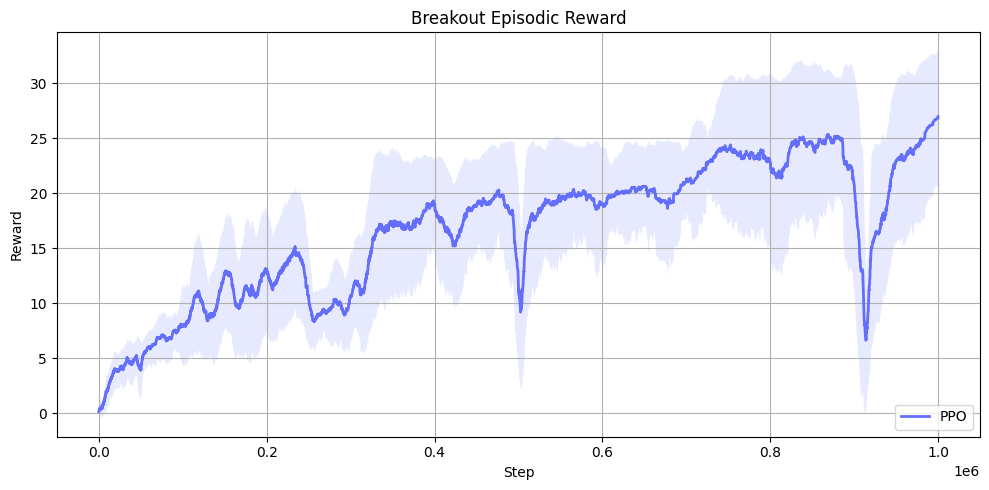

In [4]:
from lotus.plotting import plot_results

# Plot Breakout training results
plot_results(
    {'PPO': trained_agent['logs']},
    title='Breakout Episodic Reward'
)

### Train Agents on Multiple Seeds

Training multiple PQN CartPole agents in parallel on 100 seeds.

In [5]:
from lotus import PQN

# Create agent and seeds
agent = PQN.create(
    env='CartPole-v1',
    hidden_dims=(32, 32),
    verbose=False
)
num_seeds = 100
seeds = jnp.arange(num_seeds)

# Start timing
start = time.time()

# Vectorised training
train_fn = jax.vmap(agent.train, in_axes=(None, 0))
trained_agents = train_fn(agent, seeds)

# End timing
end = time.time()
print(f'Time taken to train 100 agents: {(end - start):.1f} seconds')
print(f'FPS: {(num_seeds * 1_000_000 / (end - start)):,.1f}')

Time taken to train 100 agents: 23.3 seconds
FPS: 4,296,838.3


### Train Agents with Multiple Configurations

Training multiple PQN CartPole agents in parallel with multiple λ values.

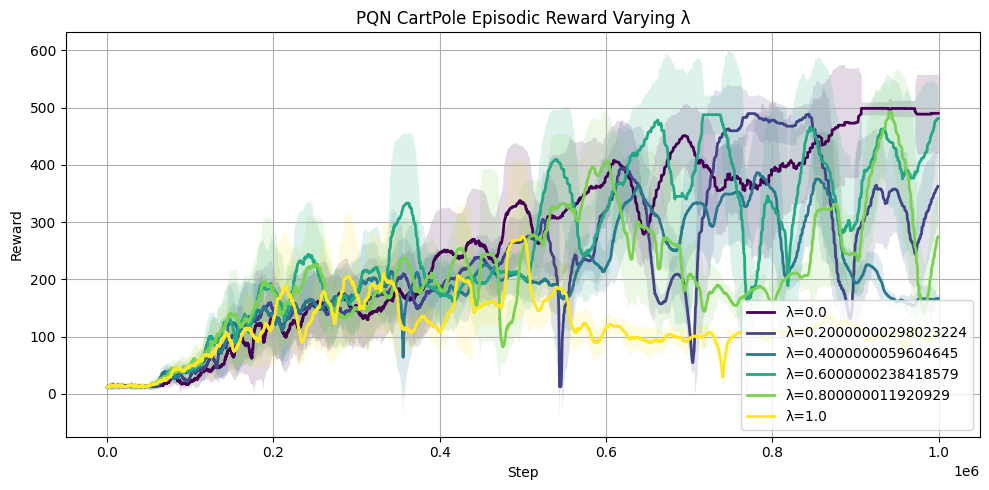

In [6]:
def create_agent(td_lambda: float):
    return PQN.create(
        env='CartPole-v1',
        td_lambda=td_lambda,
        hidden_dims=(32, 32),
        verbose=False
    )

# Create agents and seed
lambdas = jnp.array([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
agents = jax.vmap(create_agent)(lambdas)
seed = 0

# Vectorised training
train_fn = jax.vmap(agents.train, in_axes=(0, None))
trained_agents = train_fn(agents, seed)

# Gather results
results = {
    f'λ={float(key)}': jax.tree.map(lambda x: x[i], trained_agents['logs'])
    for i, key in enumerate(lambdas)
}

# Plot results
plot_results(
    results,
    title='PQN CartPole Episodic Reward Varying λ',
    colors='gradient'
)

### Train Agents with Multiple Seeds and Configurations

Training multiple CartPole agents in parallel with multiple λ values, each on 100 seeds.

In [7]:
def create_agent(td_lambda: float):
    return PQN.create(
        env='CartPole-v1',
        td_lambda=td_lambda,
        hidden_dims=(32, 32),
        verbose=False
    )

# Create agents and seeds
lambdas = jnp.array([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
agents = jax.vmap(create_agent)(lambdas)
seeds = jnp.arange(100)

# Start timing
start = time.time()

# Vectorised training
train_fn = jax.vmap(agents.train, in_axes=(0, None))
train_fn = jax.vmap(train_fn, in_axes=(None, 0))
trained_agent = train_fn(agents, seeds)

# End timing
end = time.time()
print(f'Time taken to train {len(lambdas)}00 agents: {(end - start):.1f} seconds')
print(f'FPS: {(num_seeds * len(lambdas) * 1_000_000 / (end - start)):,.1f}')

Time taken to train 600 agents: 73.4 seconds
FPS: 8,171,907.2
